<h4>Problem Statement</h4>

Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to <strong>predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.</strong>

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

<strong>Evaluation Metric:</strong> ROC AUC score

<h4>Variable Definition</h4>

1. id==>	Unique ID for the customer
2. Gender ==>	Gender of the customer

3. Age ==> Age of the customer

4. Driving_License ==>	0 : Customer does not have DL, 1 : Customer already has DL

5. Region_Code ==>	Unique code for the region of the customer

6. Previously_Insured ==>	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

7. Vehicle_Age ==>	Age of the Vehicle 

8. Vehicle_Damage ==> 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

9. Annual_Premium ==> The amount customer needs to pay as premium in the year

10. Policy_Sales_Channel ==> Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

11. Vintage ==> Number of Days, Customer has been associated with the company

12. Response (Target) ==>	1 :  Customer is interested, 0 : Customer is not interested

In [1]:
path = "C:/Machine_learning_datafiles/AnalyticsVidya/CrossSell"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')
os.chdir(path)

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import missingno as msno
import random

In [4]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import log_loss, plot_precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold, train_test_split
import catboost as cat
import lightgbm as lgb

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [6]:
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-dark')
%matplotlib inline

In [7]:
def modelMetric(model, xtrain, xval):
    tr_auc = roc_auc_score(ytrain, model.predict_proba(xtrain)[:,1])
    val_auc = roc_auc_score(yval, model.predict_proba(xval)[:,1])
    tr_bas = log_loss(ytrain, model.predict_proba(xtrain)[:,1])
    val_bas = log_loss(yval, model.predict_proba(xval)[:,1])
    print(f'Train AUC: {tr_auc.round(5)} Train Logloss : {tr_bas.round(5)}')
    print(f'Val AUC: {val_auc.round(5)} Val Logloss : {val_bas.round(5)}')

In [8]:
def figurePlotting(model):
    fig, ax= plt.subplots(1,3,figsize=(12,3.5))
    plot_confusion_matrix(model, xval, yval, ax=ax[0], display_labels=['No', 'Yes'])
    plot_roc_curve(model, xval, yval, ax=ax[1])
    plot_precision_recall_curve(model, xval, yval, ax=ax[2])
    ax[0].set_title('Confusion Matrix')
    ax[1].set_title('ROC Curve')
    ax[2].set_title('PR-Curve')
    for i in range(3):
        ax[i].grid(False)
    plt.tight_layout(pad=1.)

In [9]:
def TrainModel(model, xtrain, xval):
    if model.__class__.__name__ in ['CatBoostClassifier', 'LGBMClassifier']:
        model.fit(xtrain, ytrain, eval_set=[(xval, yval)],
                 early_stopping_rounds=250, verbose=False)
    else:
        model.fit(xtrain, ytrain)
    modelMetric(model, xtrain, xval)
    return model

In [10]:
def skfoldPred(model, X, testset):
    avg_auc, avg_lloss = 0,0
    
    test_preds = []
    train_preds = np.zeros(len(X))
    
    for fold, (tr_idx, val_idx) in enumerate(skfold.split(X, y), start=1):
        x_train, y_train = X.iloc[tr_idx], y.iloc[tr_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if model.__class__.__name__ in ['CatBoostClassifier', 'LGBMClassifier']:
            model.fit(x_train, y_train, eval_set=[(x_val, y_val)], 
                      early_stopping_rounds=250, verbose=False)
        else:
            model.fit(x_train, y_train)
        
        val_auc = roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
        val_llos = log_loss(y_val, model.predict_proba(x_val)[:,1])
        print(f'Fold {fold} ===> Val AUC: {val_auc.round(5)} Val Logloss:{val_llos.round(5)}')
        
        avg_auc += val_auc
        avg_lloss += val_llos
        
        train_preds[val_idx] = model.predict_proba(x_val)[:,1]
        
        y_pred = model.predict_proba(testset)[:,1]
        test_preds.append(y_pred)
    print(f'AVG AUC: {avg_auc/fold} AVG Logloss {avg_lloss/fold}')
    return np.mean(test_preds, 0).astype('float32'), train_preds

In [11]:
def read_files(filename): return pd.read_csv(filename)

In [12]:
def stackModels(meta_estimator, train_stack, test_stack, target):
    stack_preds = meta_estimator.fit(train_stack, target).predict(test_stack)
    return stack_preds.astype('float32')

In [13]:
train = read_files('Train.csv')
test = read_files('Test.csv')
subfile = read_files('sample_submission.csv')

In [14]:
#Shape of Data
train.shape, test.shape

((381109, 12), (127037, 11))

In [15]:
train.head(4)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0


In [16]:
test.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199


In [17]:
train.isna().any().sum(), test.isna().any().sum()

(0, 0)

#### No Missing values in both train and test sets

In [18]:
#checking duplicate data in train
train.duplicated().shape

(381109,)

#### No duplicated rows in training data

In [19]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [20]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [21]:
test.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000


#### Target Distribution

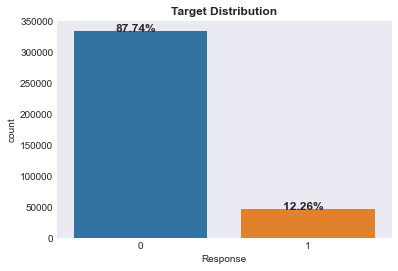

In [22]:
ax = sns.countplot('Response', data=train)
plt.title('Target Distribution', fontweight='bold')
for i in ax.patches:
    plt.text(x=i.get_x()+0.25, y=i.get_height()+0.3, 
             s=str(round(i.get_height()/train.shape[0] * 100, 2))+'%', 
             fontsize=12, fontweight='bold')

#### As we can see the target distribution is highly unbalanced. We will deal with this problem later

In [23]:
train.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

#### EDA

In [24]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

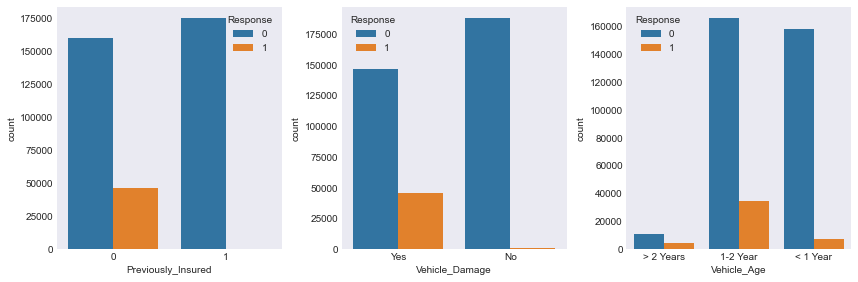

In [25]:
fig,ax= plt.subplots(1,3,figsize=(12,4))
sns.countplot('Previously_Insured', data=train, hue='Response', ax=ax[0])
sns.countplot('Vehicle_Damage', data=train, hue='Response', ax=ax[1])
sns.countplot('Vehicle_Age', data=train, hue='Response', ax=ax[2])
plt.tight_layout(pad=1.);

Those Previously insured are not likely to respond. It is expected as insurance is targetted at people who do not have an insurance yet.

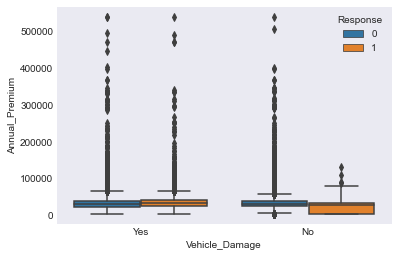

In [26]:
sns.boxplot(y='Annual_Premium', x='Vehicle_Damage', data=train, hue='Response');

#### Feature Engineering

In [27]:
def agebins(x):
    if x in range(20,30): return 1
    elif x in range(30,37): return 2
    elif x in range(37,45): return 3
    elif x in range(45,56): return 4
    elif x in range(56,66): return 5
    else: return 6

In [28]:
train['AgeBins'] = train.Age.apply(agebins)
test['AgeBins'] = test.Age.apply(agebins)

In [30]:
regionalChannels_count = train.groupby('Region_Code').Policy_Sales_Channel.nunique()
age_channel = train.groupby(['Age']).Policy_Sales_Channel.nunique()
channelRegions = train.groupby('Policy_Sales_Channel').Region_Code.nunique()

regionalChannels_count.name = 'regionalChannelCount'
age_channel.name= 'Age_ChannelCount'
channelRegions.name = 'ChannelRegion'

In [35]:
AgeBins_Premium = train.groupby('AgeBins').Annual_Premium.mean()
Region_AgeBins_Premium = train.groupby(['Region_Code','AgeBins']).Annual_Premium.mean()

AgeBins_Premium.name = 'Age_mean_premium'
Region_AgeBins_Premium.name= 'AgeRegional_meanPremium'

In [36]:
Age_prevInsured = train.groupby(['AgeBins']).Previously_Insured.sum()
region_prevInsured = train.groupby(['Region_Code']).Previously_Insured.sum()
region_Age_prevInsured = train.groupby(['AgeBins','Region_Code']).Previously_Insured.sum()

Age_prevInsured.name = 'Age_Prev_Insured_count'
region_Age_prevInsured.name = 'Age_Insurance_count_byRegion'
region_prevInsured.name = 'RegionInsurance_count'

In [38]:
age_vehicle_insured_Premium = train.groupby(['AgeBins','Vehicle_Damage',
                                                     'Previously_Insured']).Annual_Premium.mean()
age_vehicle_insured_Premium.name= 'Agebin_Vehi_Insur_Premium'

In [39]:
vehicle_damage_age_percentInsurance = train.groupby(['Vehicle_Age','Vehicle_Damage'
                                                    ]).Previously_Insured.sum().transform(lambda x: x/x.sum()*100)
vehicle_damage_age_percentInsurance.name = 'Vehi_Age_Damage_PercentInsurance'

#### Merging

In [41]:
train = train.merge(regionalChannels_count, on=regionalChannels_count.index.names, how='left')
train = train.merge(age_channel, on=age_channel.index.names, how='left')
train = train.merge(channelRegions, on=channelRegions.index.names, how='left')
train = train.merge(AgeBins_Premium, on=AgeBins_Premium.index.names, how='left')
train = train.merge(Region_AgeBins_Premium, on=Region_AgeBins_Premium.index.names, how='left')
train = train.merge(Age_prevInsured,  on=Age_prevInsured.index.names, how='left')
train = train.merge(region_prevInsured, on=region_prevInsured.index.names, how='left')
train = train.merge(region_Age_prevInsured, on=region_Age_prevInsured.index.names, how='left')
train = train.merge(age_vehicle_insured_Premium, on=age_vehicle_insured_Premium.index.names, how='left')
train = train.merge(vehicle_damage_age_percentInsurance, on=vehicle_damage_age_percentInsurance.index.names, how='left')

In [42]:
test = test.merge(regionalChannels_count, on=regionalChannels_count.index.names, how='left')
test = test.merge(age_channel, on=age_channel.index.names, how='left')
test = test.merge(channelRegions, on=channelRegions.index.names, how='left')
test = test.merge(AgeBins_Premium, on=AgeBins_Premium.index.names, how='left')
test = test.merge(Region_AgeBins_Premium, on=Region_AgeBins_Premium.index.names, how='left')
test = test.merge(Age_prevInsured,  on=Age_prevInsured.index.names, how='left')
test = test.merge(region_prevInsured, on=region_prevInsured.index.names, how='left')
test = test.merge(region_Age_prevInsured, on=region_Age_prevInsured.index.names, how='left')
test = test.merge(age_vehicle_insured_Premium, on=age_vehicle_insured_Premium.index.names, how='left')
test = test.merge(vehicle_damage_age_percentInsurance, on=vehicle_damage_age_percentInsurance.index.names, how='left')

In [44]:
train['Region_PolicyChannel'] = train.Region_Code.astype('str') + '__' + train.Policy_Sales_Channel.astype('str')
test['Region_PolicyChannel'] = test.Region_Code.astype('str') + '__' + test.Policy_Sales_Channel.astype('str')

train['Region_Count'] = train.Region_Code.map(train.Region_Code.value_counts())
test['Region_Count'] = test.Region_Code.map(train.Region_Code.value_counts())

In [62]:
cat_cols = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Region_PolicyChannel']
num_cols = [col for col in test.columns if col not in cat_cols and col != 'id']

In [63]:
train.Vehicle_Age = train.Vehicle_Age.replace({'< 1 Year' : 1, '1-2 Year' : 2, '> 2 Years' : 3})

test.Vehicle_Age = test.Vehicle_Age.replace({'< 1 Year' : 1, '1-2 Year' : 2, '> 2 Years' : 3})

In [64]:
train.Vehicle_Damage = train.Vehicle_Damage.replace({'No' : 0, 'Yes' : 1})
test.Vehicle_Damage = test.Vehicle_Damage.replace({'No' : 0, 'Yes' : 1})

train.Gender = train.Gender.replace({'Female': 0, 'Male' : 1})
test.Gender = test.Gender.replace({'Female': 0, 'Male' : 1})

In [65]:
len(num_cols)+len(cat_cols)

23

In [67]:
premium_cols = [col for col in train.columns if 'premium' in col.lower()]

train[premium_cols] = np.sqrt(train[premium_cols])
test[premium_cols] = np.sqrt(test[premium_cols])

In [68]:
df= train.append(test)[train.columns]

In [69]:
df.Region_PolicyChannel = df.Region_PolicyChannel.astype('category').cat.codes

In [70]:
train.Region_PolicyChannel = df[df.Response.notna()].Region_PolicyChannel
test.Region_PolicyChannel = df[df.Response.isna()].Region_PolicyChannel

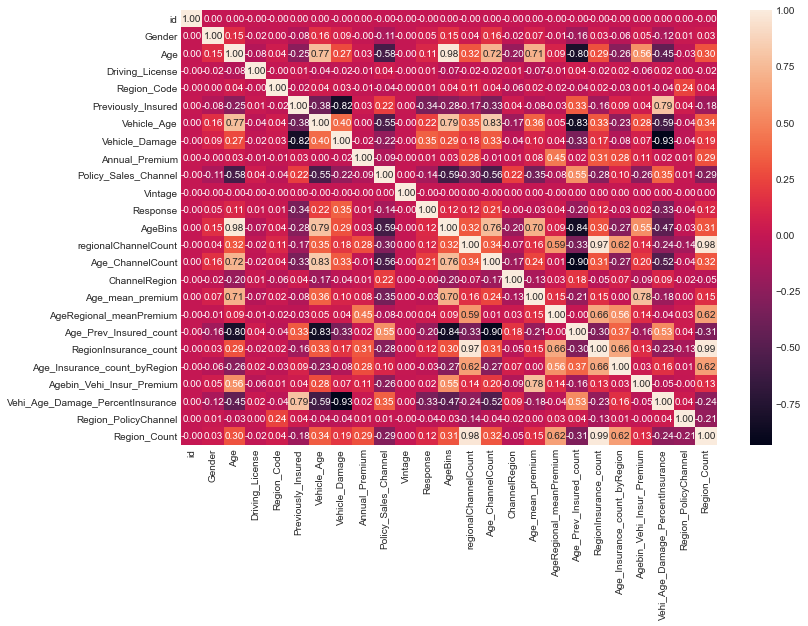

In [72]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True, fmt='.2f');

In [73]:
drop = ['AgeBins']

#### Modelling

In [74]:
def TrainTestData(train, test): 
    X = train.drop(['id', 'Response']+drop, axis=1)
    test_c = test.drop(['id']+drop, axis=1)
    return X, test_c

In [75]:
def data_split(X,y):
    xtrain, xval, ytrain, yval = train_test_split(X, y, random_state=seed, 
                                                  test_size=0.3, stratify=y)
    return xtrain, xval, ytrain, yval

In [76]:
test.fillna(0, inplace=True)

In [77]:
X, test_c = TrainTestData(train, test)
y= train.Response

In [78]:
xtrain, xval, ytrain, yval = data_split(X, y)

In [79]:
xtrain.shape, xval.shape

((266776, 22), (114333, 22))

In [80]:
catm = cat.CatBoostClassifier(random_seed=seed, early_stopping_rounds=250, silent=True, n_estimators=1000,
                              learning_rate=0.07, subsample=0.9, eval_metric='AUC')

lgbm = lgb.LGBMClassifier(random_state=seed, n_estimators=1000, learning_rate=0.02, metrics='auc',subsample_freq=2,
                         subsample=0.9, colsample_bytree=0.55, num_leaves=40, scale_pos_weight=1)

gb = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, n_estimators=500, n_iter_no_change=100,
                                subsample=0.7, min_samples_leaf=5, min_samples_split=10, warm_start=False, 
                                validation_fraction=0.2, max_depth=4, max_features='log2')

ext = ExtraTreesClassifier(random_state=seed, min_samples_leaf=10, min_samples_split=10, n_jobs=-1, n_estimators=500,
                           max_samples=0.5, criterion='entropy', warm_start=False)

#### Training

In [81]:
def plotImportance(model, title=None, ax=None):
    imp = pd.Series(model.feature_importances_, index=xtrain.columns).sort_values()
    imp.plot.barh(title=title)
    if ax:
        imp.plot.barh(ax=ax, title=title)

In [82]:
TrainModel(ext, xtrain, xval);

Train AUC: 0.88727 Train Logloss : 0.24988
Val AUC: 0.85503 Val Logloss : 0.26619


In [83]:
TrainModel(gb, xtrain, xval);

Train AUC: 0.86393 Train Logloss : 0.26144
Val AUC: 0.85903 Val Logloss : 0.26389


In [84]:
TrainModel(lgbm, xtrain, xval);

Train AUC: 0.87157 Train Logloss : 0.25565
Val AUC: 0.85993 Val Logloss : 0.26339


In [85]:
TrainModel(catm, xtrain, xval);

Train AUC: 0.86512 Train Logloss : 0.2607
Val AUC: 0.85998 Val Logloss : 0.26348


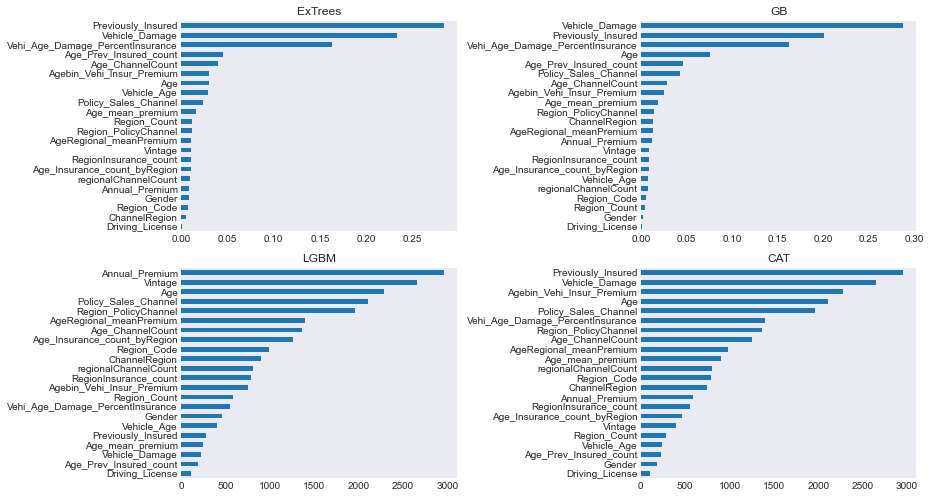

In [86]:
fig,(ax,ax1) = plt.subplots(2,2,figsize=(13,7))
plotImportance(ext, title='ExTrees', ax=ax[0])
plotImportance(gb, title='GB', ax=ax[1])
plotImportance(lgbm, title='LGBM', ax=ax1[0])
plotImportance(catm, title='CAT', ax=ax1[1])
plt.tight_layout(pad=1.)

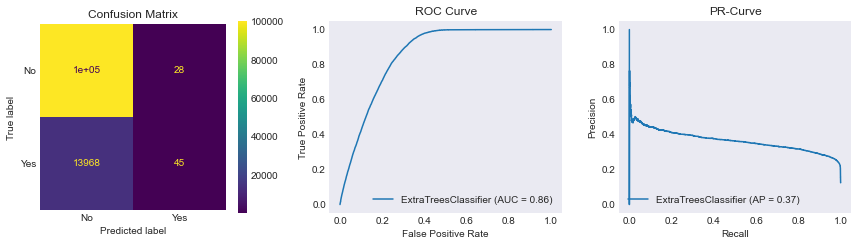

In [87]:
figurePlotting(ext)

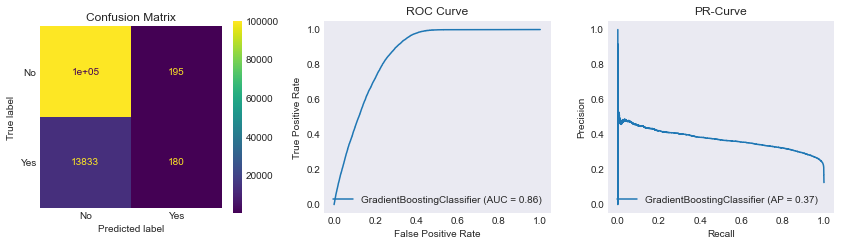

In [88]:
figurePlotting(gb)

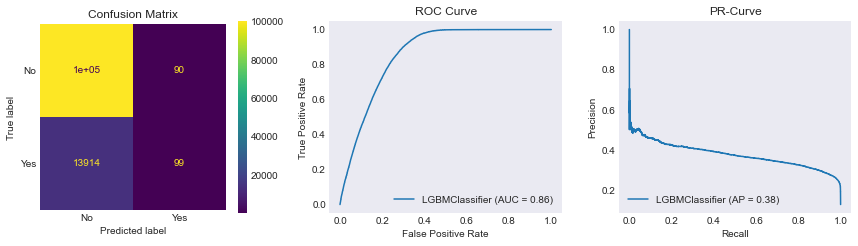

In [89]:
figurePlotting(lgbm)

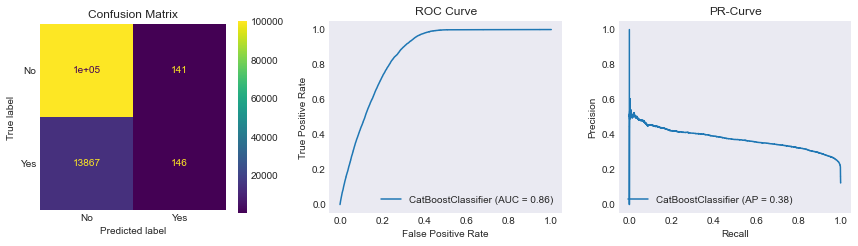

In [90]:
figurePlotting(catm)

#### Predictions

In [91]:
skfold= StratifiedKFold(random_state=seed, shuffle=True)

In [92]:
ext_pred, ext_tr = skfoldPred(ext, X, test_c)

Fold 1 ===> Val AUC: 0.85201 Val Logloss:0.26705
Fold 2 ===> Val AUC: 0.85199 Val Logloss:0.26738
Fold 3 ===> Val AUC: 0.85326 Val Logloss:0.26712
Fold 4 ===> Val AUC: 0.8552 Val Logloss:0.26666
Fold 5 ===> Val AUC: 0.85647 Val Logloss:0.26595
AVG AUC: 0.8537861678696116 AVG Logloss 0.26683240691657295


In [93]:
gb_pred, gb_tr = skfoldPred(gb, X, test_c)

Fold 1 ===> Val AUC: 0.85666 Val Logloss:0.26539
Fold 2 ===> Val AUC: 0.85597 Val Logloss:0.26524
Fold 3 ===> Val AUC: 0.85724 Val Logloss:0.26484
Fold 4 ===> Val AUC: 0.8589 Val Logloss:0.2644
Fold 5 ===> Val AUC: 0.86002 Val Logloss:0.2639
AVG AUC: 0.8577575420590721 AVG Logloss 0.26475410031251184


In [94]:
lgb_pred, lgb_tr = skfoldPred(lgbm, X, test_c)

Fold 1 ===> Val AUC: 0.85781 Val Logloss:0.26405
Fold 2 ===> Val AUC: 0.85701 Val Logloss:0.2646
Fold 3 ===> Val AUC: 0.85852 Val Logloss:0.26429
Fold 4 ===> Val AUC: 0.85996 Val Logloss:0.26387
Fold 5 ===> Val AUC: 0.86089 Val Logloss:0.26337
AVG AUC: 0.8588398625621696 AVG Logloss 0.26403281243882326


In [95]:
cat_pred, cat_tr = skfoldPred(catm, X, test_c)

Fold 1 ===> Val AUC: 0.8577 Val Logloss:0.26411
Fold 2 ===> Val AUC: 0.8566 Val Logloss:0.26484
Fold 3 ===> Val AUC: 0.85852 Val Logloss:0.26433
Fold 4 ===> Val AUC: 0.85975 Val Logloss:0.26405
Fold 5 ===> Val AUC: 0.86073 Val Logloss:0.26361
AVG AUC: 0.858659574813929 AVG Logloss 0.26418847132991036


In [96]:
gc.collect()

44783

In [97]:
train_stack = pd.DataFrame(np.c_[ext_tr, gb_tr, lgb_tr, cat_tr], columns=['ext', 'gb', 'lgb', 'cat'])
test_stack = pd.DataFrame(np.c_[ext_pred, gb_pred, lgb_pred, cat_pred], columns=['ext', 'gb', 'lgb', 'cat'])

In [99]:
linreg = LinearRegression()

In [102]:
stack = np.abs(stackModels(linreg, train_stack, test_stack, y))

In [104]:
blend = 0.15 * ext_pred + 0.20 * gb_pred + 0.35*lgb_pred + 0.3*cat_pred

In [105]:
ext_df = subfile.copy()
ext_df['Response'] = ext_pred

In [106]:
gb_df = subfile.copy()
gb_df['Response'] = gb_pred

In [107]:
lgb_df = subfile.copy()
lgb_df['Response'] = lgb_pred

In [108]:
cat_df = subfile.copy()
cat_df['Response'] = cat_pred

In [109]:
blend_df = subfile.copy()
blend_df['Response'] = blend

In [110]:
stack_df = subfile.copy()
stack_df['Response'] = stack

In [111]:
pd.concat([test_stack,pd.DataFrame({'blend':blend, 'stack' : stack})],1)

,ext,gb,lgb,cat,blend,stack
0,0.000268,0.000614,0.000395,0.000498,0.000451,0.000123
1,0.288093,0.289045,0.297360,0.315279,0.299682,0.304708
2,0.285143,0.296673,0.290854,0.291686,0.291411,0.292968
3,0.012780,0.012034,0.006173,0.008976,0.009177,0.006756
4,0.000766,0.000478,0.000320,0.000245,0.000396,0.000294
...,...,...,...,...,...,...
127032,0.006381,0.000464,0.000399,0.000368,0.001300,0.000474
127033,0.362006,0.358045,0.360322,0.353530,0.358081,0.359139
127034,0.000041,0.000338,0.000259,0.000188,0.000221,0.000328
127035,0.000145,0.000650,0.000416,0.000108,0.000330,0.000240


In [112]:
pd.concat([test_stack,pd.DataFrame({'blend':blend, 'stack' : stack})],1).corr()

,ext,gb,lgb,cat,blend,stack
ext,1.000000,0.981777,0.983064,0.982275,0.987972,0.981851
gb,0.981777,1.000000,0.996366,0.997010,0.998069,0.997561
lgb,0.983064,0.996366,1.000000,0.997232,0.998871,0.999541
cat,0.982275,0.997010,0.997232,1.000000,0.998745,0.998899
blend,0.987972,0.998069,0.998871,0.998745,1.000000,0.999273
stack,0.981851,0.997561,0.999541,0.998899,0.999273,1.000000


In [113]:
ext_df.to_csv('predictions/extrees1.csv', index=False)
gb_df.to_csv('predictions/gb1.csv', index=False)
lgb_df.to_csv('predictions/lgb1.csv', index=False)
cat_df.to_csv('predictions/cat1.csv', index=False)
blend_df.to_csv('predictions/blend1.csv', index=False)
stack_df.to_csv('predictions/stack1.csv', index=False)

In [114]:
gc.collect()

140